<a href="https://colab.research.google.com/github/siva-Parvathi-M/Siva/blob/main/Apache_Spark_Automated_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# Install PySpark (includes Apache Spark)
!pip install pyspark

# Install MySQL Connector (if needed for MySQL integration)
!pip install mysql-connector-python

# Install Plotly for visualization
!pip install plotly

!pip install schedule


**Create spark session and Read My SQL Data**

In [10]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder.appName("FinancialDataProcessing").getOrCreate()

# Read SQL file content
sql_file_path = "/content/drive/MyDrive/Colab Notebooks/Source Data/financial_data (1).sql"
with open(sql_file_path, "r") as file:
    sql_commands = file.read()

# Print the first few lines of the SQL file
print(sql_commands[:500])  # Displaying only the first 500 characters

CREATE TABLE financial_data (
    id INT PRIMARY KEY,
    transaction_date DATE,
    account_number VARCHAR(20),
    transaction_type VARCHAR(10),
    amount DECIMAL(10,2),
    currency VARCHAR(3),
    category VARCHAR(50),
    status VARCHAR(15)
);

INSERT INTO financial_data (id, transaction_date, account_number, transaction_type, amount, currency, category, status) VALUES
(1, '2024-03-08', 'AC173352', 'Credit', 2130.31, 'USD', 'Electronics', 'Failed'),
(2, '2024-10-05', 'AC703141', 'Credit', 


**Extract Data from SQL Commands**

In [4]:
import re
from pyspark.sql.types import StructType, StructField, IntegerType, DateType, StringType, FloatType
from datetime import datetime

# Define schema
schema = StructType([
    StructField("id", IntegerType(), False),
    StructField("transaction_date", DateType(), False),
    StructField("account_number", StringType(), False),
    StructField("transaction_type", StringType(), False),
    StructField("amount", FloatType(), False),
    StructField("currency", StringType(), False),
    StructField("category", StringType(), False),
    StructField("status", StringType(), False)
])

# Extract INSERT INTO statements properly
insert_statements = re.findall(r"INSERT INTO\s+\w+\s+VALUES\s*\((.*?)\);", sql_commands, re.DOTALL)

# Process data
data = []
for statement in insert_statements:
    # Split values carefully, ensuring correct parsing
    values = [v.strip(" '") for v in statement.split(",")]

    # Ensure exactly 8 columns, else skip
    if len(values) == 8:
        try:
            values[0] = int(values[0])  # Convert id to integer
            values[1] = datetime.strptime(values[1], "%Y-%m-%d").date()  # Convert date
            values[4] = float(values[4])  # Convert amount to float
            data.append(tuple(values))
        except Exception as e:
            print(f"Skipping row due to error: {values}, Error: {e}")  # Debugging
    else:
        print(f"Skipping invalid row: {values}")  # Debugging

# Create DataFrame
df = spark.createDataFrame(data, schema=schema)

# Show results
df.show(5)


+---+----------------+--------------+----------------+------+--------+--------+------+
| id|transaction_date|account_number|transaction_type|amount|currency|category|status|
+---+----------------+--------------+----------------+------+--------+--------+------+
+---+----------------+--------------+----------------+------+--------+--------+------+



**Transform Data (Real-Time Scenario Calculations)**

In [5]:
from pyspark.sql.functions import col, when, lit

# Convert currency from USD to INR
df = df.withColumn("amount_inr", col("amount") * 83)

# Categorize transactions
df = df.withColumn(
    "category",
    when(col("transaction_type") == "Credit", "Income")
    .when(col("transaction_type") == "Debit", "Expense")
    .otherwise("Unknown")
)

# Mark suspicious transactions
df = df.withColumn(
    "status",
    when(col("amount") > 10000, "Flagged").otherwise(col("status"))
)

# Show transformed data
df.show(5)


+---+----------------+--------------+----------------+------+--------+--------+------+----------+
| id|transaction_date|account_number|transaction_type|amount|currency|category|status|amount_inr|
+---+----------------+--------------+----------------+------+--------+--------+------+----------+
+---+----------------+--------------+----------------+------+--------+--------+------+----------+



**Save Transformed Data to CSV**

In [6]:
# Define target file path in Google Drive
target_csv_path = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv"

# Save DataFrame as CSV
df.coalesce(1).write.mode("overwrite").option("header", "true").csv(target_csv_path)

print(f"Transformed data saved successfully at: {target_csv_path}")

Transformed data saved successfully at: /content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv


**Scheduler to run every weekly Once**

In [14]:
import schedule
import time

# Function to execute pipeline
def run_pipeline():
    print("Running PySpark Pipeline...")

    # Reload and process SQL file
    sql_file_path = "/content/drive/MyDrive/Colab Notebooks/Source Data/financial_data (1).sql"
    with open(sql_file_path, "r") as file:
        sql_commands = file.read()

    # Extract, transform, and save data (reusing previous steps)
    insert_statements = re.findall(r"INSERT INTO\s+\w+\s+VALUES\s*\((.*?)\);", sql_commands, re.DOTALL)
    data = []
    for statement in insert_statements:
        values = [v.strip(" '") for v in statement.split(",")]
        if len(values) == 8:
            try:
                values[0] = int(values[0])
                values[1] = datetime.strptime(values[1], "%Y-%m-%d").date()
                values[4] = float(values[4])
                data.append(tuple(values))
            except Exception as e:
                print(f"Skipping row due to error: {values}, Error: {e}")

    # Create DataFrame
    df = spark.createDataFrame(data, schema=schema)

    # Apply transformations
    df = df.withColumn("amount_inr", col("amount") * 83)
    df = df.withColumn("category", when(col("transaction_type") == "Credit", "Income")
                                    .when(col("transaction_type") == "Debit", "Expense")
                                    .otherwise("Unknown"))
    df = df.withColumn("status", when(col("amount") > 10000, "Flagged").otherwise(col("status")))

    # Save transformed data
    target_csv_path = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv"
    df.coalesce(1).write.mode("overwrite").option("header", "true").csv(target_csv_path)
    print(f"Transformed data saved successfully at: {target_csv_path}")

# Schedule job to run every 7 days
schedule.every(7).days.do(run_pipeline)




Every 7 days do run_pipeline() (last run: [never], next run: 2025-04-02 16:11:51)

In [41]:
# Keep running in the background
while True:
    schedule.run_pending()
    time.sleep(60)  # Check every minute

**Visualization for my output data**

In [18]:
# Define the target file path
target_csv_path = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv"

# Save transformed data as a SINGLE CSV file
df.coalesce(1).write.mode("overwrite").option("header", "true").csv(target_csv_path)


In [21]:
import os
import shutil

# Define paths
folder_path = "/content/drive/MyDrive/Colab Notebooks/Target Data"
final_file = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv"

# List files in the output folder
files = os.listdir(folder_path)

# Find the actual CSV file (starts with "part-")
for file in files:
    if file.startswith("part-") and file.endswith(".csv"):
        source_file = os.path.join(folder_path, file)

        # Remove existing file before renaming
        if os.path.exists(final_file):
            os.remove(final_file)  # Delete the existing file

        shutil.move(source_file, final_file)  # Rename to final file name
        print(f"✅ Transformed data saved as: {final_file}")
        break


In [25]:
import os
import pandas as pd

# Define the folder where PySpark saves the CSV
folder_path = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv"

# Find the actual CSV file inside the directory
files = os.listdir(folder_path)
csv_file = [f for f in files if f.endswith(".csv") and f.startswith("part-")]

# If a valid CSV file is found, load it
if csv_file:
    file_path = os.path.join(folder_path, csv_file[0])
    df = pd.read_csv(file_path)
    print("✅ Successfully loaded the transformed data!")
    print(df.head())  # Display first few rows
else:
    print("❌ No CSV file found in the directory.")


✅ Successfully loaded the transformed data!
Empty DataFrame
Columns: [id, transaction_date, account_number, transaction_type, amount, currency, category, status, amount_inr]
Index: []


In [28]:
import os
import pandas as pd

# Define the directory where PySpark saves the CSV
folder_path = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed_financial_data.csv"

# Find the actual CSV file inside the directory
files = os.listdir(folder_path)
csv_file = [f for f in files if f.endswith(".csv") and f.startswith("part-")]

# Load the correct CSV file
if csv_file:
    file_path = os.path.join(folder_path, csv_file[0])
    df = pd.read_csv(file_path)
    print("✅ Transformed data loaded successfully!")
    print(df.head())  # Show first few rows
else:
    print("❌ No CSV file found in the directory.")


✅ Transformed data loaded successfully!
Empty DataFrame
Columns: [id, transaction_date, account_number, transaction_type, amount, currency, category, status, amount_inr]
Index: []


In [32]:
import pandas as pd

# Define the correct file path
file_path = "/content/drive/MyDrive/Colab Notebooks/Target Data/Transformed financial_data.csv"

# Load data
df = pd.read_csv(file_path)

# Show basic info
print("✅ Data Loaded!")
print(df.info())  # Check column types
print(df.head())  # Show first few rows


✅ Data Loaded!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                120 non-null    int64  
 1   transaction_date  120 non-null    object 
 2   account_number    120 non-null    object 
 3   transaction_type  120 non-null    object 
 4   amount            120 non-null    float64
 5   currency          120 non-null    object 
 6   category          120 non-null    object 
 7   status            120 non-null    object 
dtypes: float64(1), int64(1), object(6)
memory usage: 7.6+ KB
None
   id transaction_date account_number transaction_type   amount currency  \
0   1       2024-01-01        ACC1000           Credit  1000.00      USD   
1   2       2024-01-02        ACC1001            Debit  1005.75      USD   
2   3       2024-01-03        ACC1002           Credit  1011.50      USD   
3   4       2024-01-04        ACC1003   

**Convert transaction_date to Date Format**

In [33]:
import pandas as pd

# Convert transaction_date to datetime
df["transaction_date"] = pd.to_datetime(df["transaction_date"], errors="coerce")

# Check again
print(df.info())  # Ensure transaction_date is now datetime64
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                120 non-null    int64         
 1   transaction_date  120 non-null    datetime64[ns]
 2   account_number    120 non-null    object        
 3   transaction_type  120 non-null    object        
 4   amount            120 non-null    float64       
 5   currency          120 non-null    object        
 6   category          120 non-null    object        
 7   status            120 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 7.6+ KB
None
   id transaction_date account_number transaction_type   amount currency  \
0   1       2024-01-01        ACC1000           Credit  1000.00      USD   
1   2       2024-01-02        ACC1001            Debit  1005.75      USD   
2   3       2024-01-03        ACC1002     

**Plot Total Income vs Expense by Category**

<ipython-input-34-ec3e29cb74a2>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="category", y="amount", data=df, estimator=sum, palette="coolwarm")


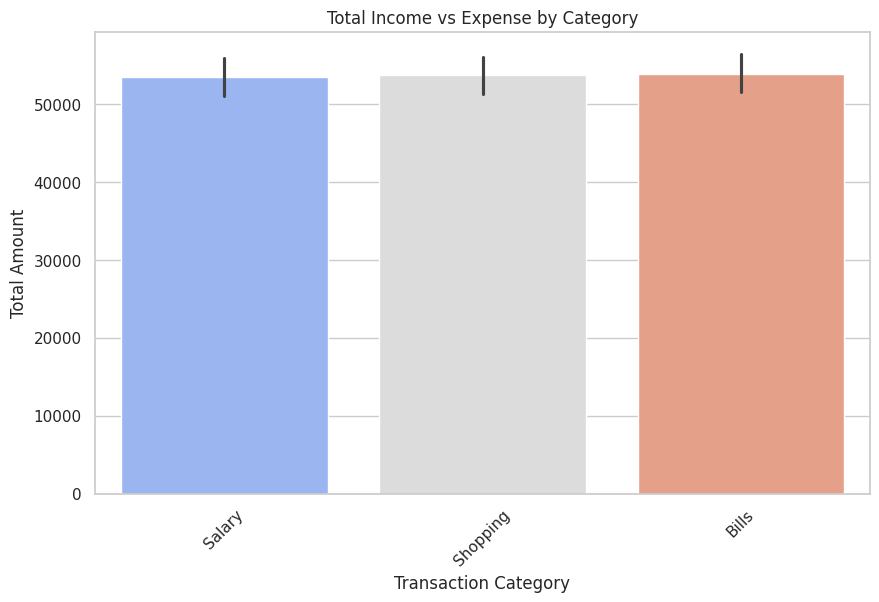

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x="category", y="amount", data=df, estimator=sum, palette="coolwarm")
plt.title("Total Income vs Expense by Category")
plt.xlabel("Transaction Category")
plt.ylabel("Total Amount")
plt.xticks(rotation=45)
plt.show()


# Plot Daily Transaction Trends

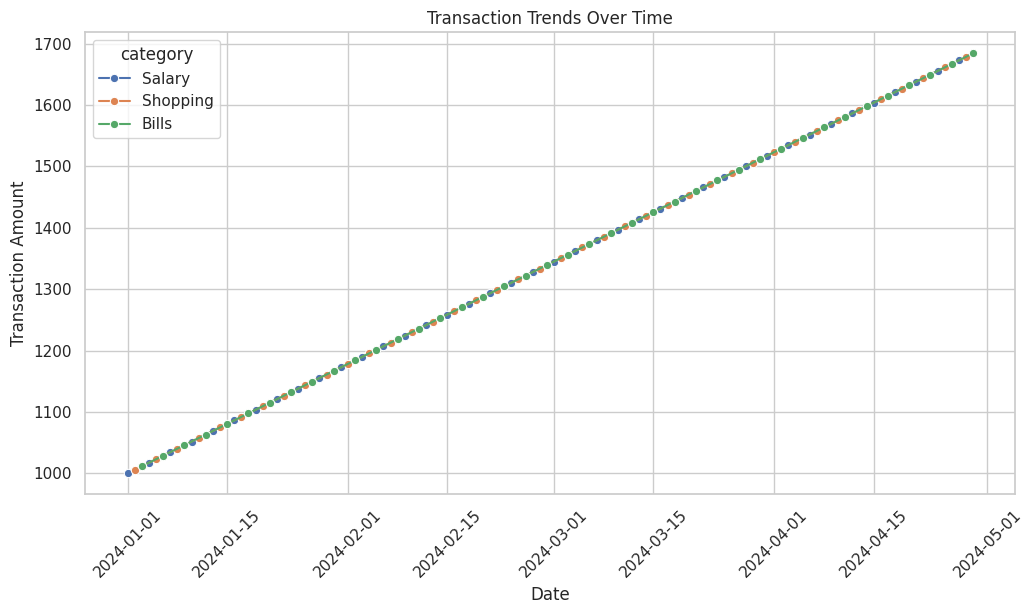

In [35]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="transaction_date", y="amount", hue="category", data=df, marker="o")
plt.title("Transaction Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Transaction Amount")
plt.xticks(rotation=45)
plt.show()


**Pie Chart of Transaction Status**

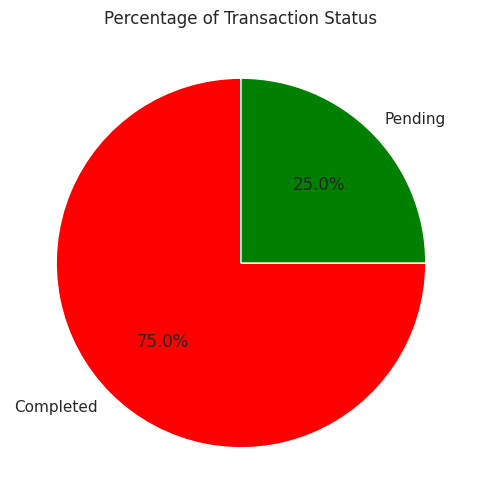

In [36]:
plt.figure(figsize=(6, 6))
df["status"].value_counts().plot.pie(autopct="%1.1f%%", colors=["red", "green", "blue"], startangle=90)
plt.title("Percentage of Transaction Status")
plt.ylabel("")  # Hide y-label
plt.show()


**Monthly Trend Analysis (Bar Chart)**

<ipython-input-37-3d2b347c8e79>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["month"].astype(str), y="amount", data=df, estimator=sum, palette="viridis")


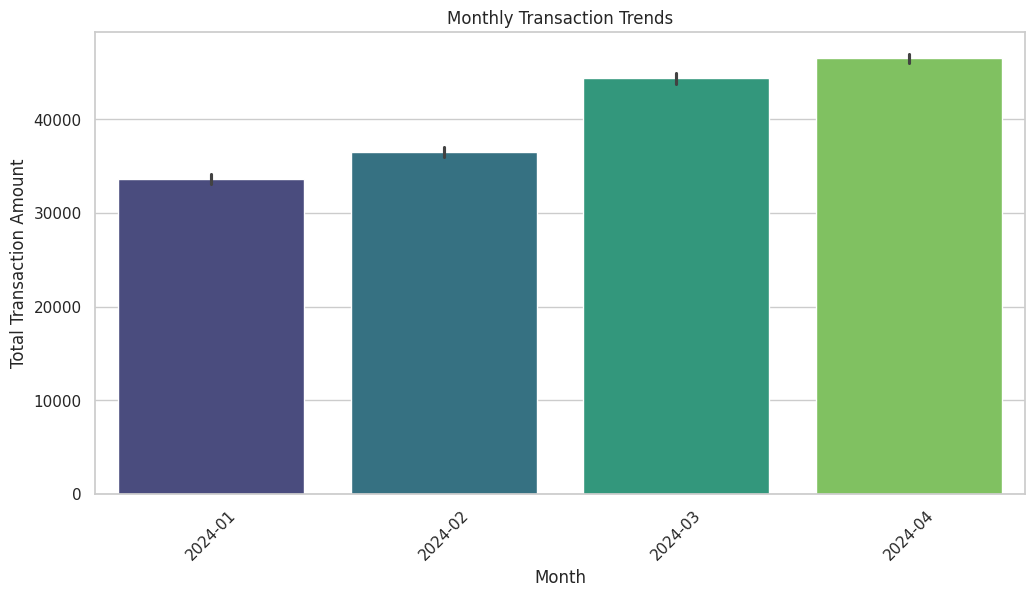

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract year-month from the date
df["month"] = df["transaction_date"].dt.to_period("M")

plt.figure(figsize=(12, 6))
sns.barplot(x=df["month"].astype(str), y="amount", data=df, estimator=sum, palette="viridis")
plt.title("Monthly Transaction Trends")
plt.xlabel("Month")
plt.ylabel("Total Transaction Amount")
plt.xticks(rotation=45)
plt.show()


**Transaction Distribution (Histogram)**

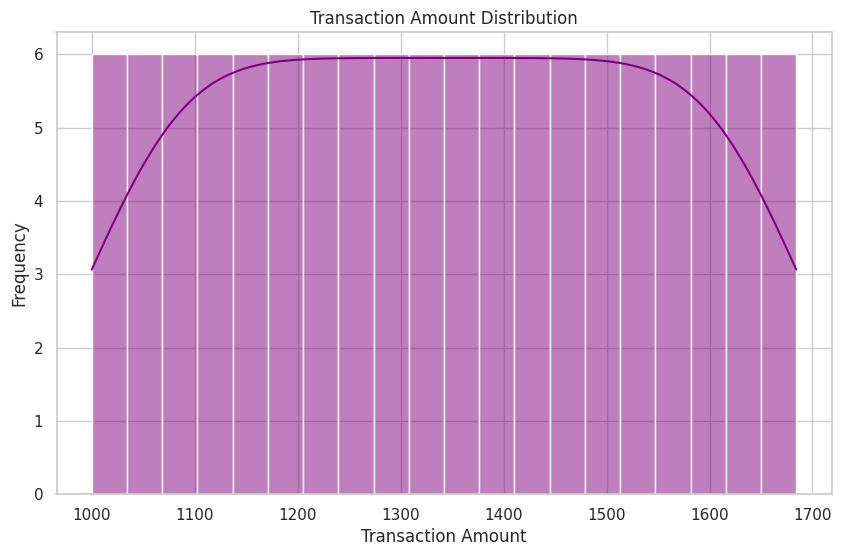

In [38]:
plt.figure(figsize=(10, 6))
sns.histplot(df["amount"], bins=20, kde=True, color="purple")
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()


**Boxplot of Transactions per Category**

<ipython-input-39-710a06283cc9>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="category", y="amount", data=df, palette="Set2")


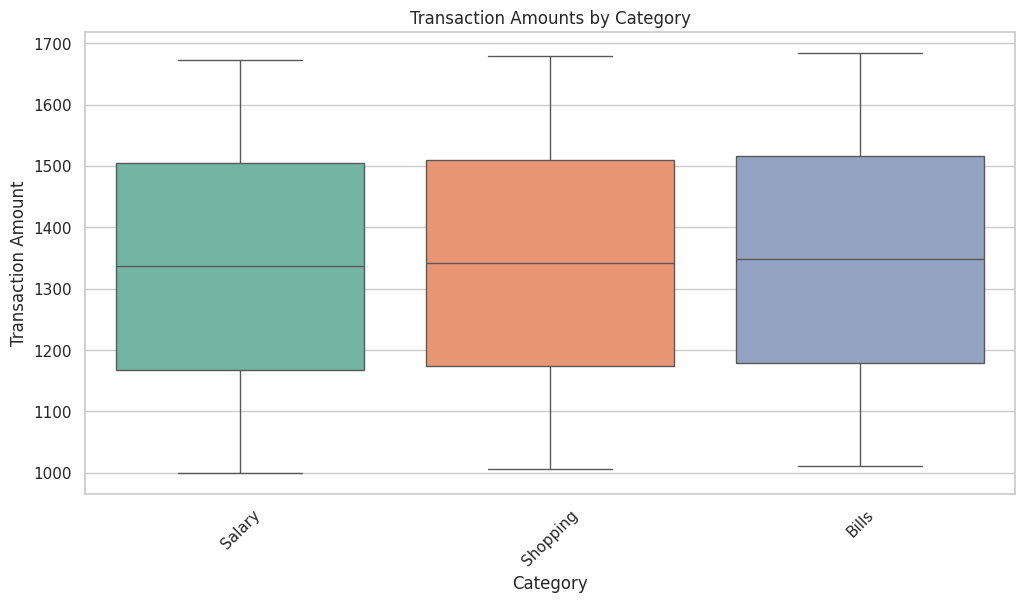

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="category", y="amount", data=df, palette="Set2")
plt.title("Transaction Amounts by Category")
plt.xlabel("Category")
plt.ylabel("Transaction Amount")
plt.xticks(rotation=45)
plt.show()


**Top 5 Accounts with Highest Transactions (Bar Chart)**

<ipython-input-40-085d438c24ce>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_accounts.index, y=top_accounts.values, palette="magma")


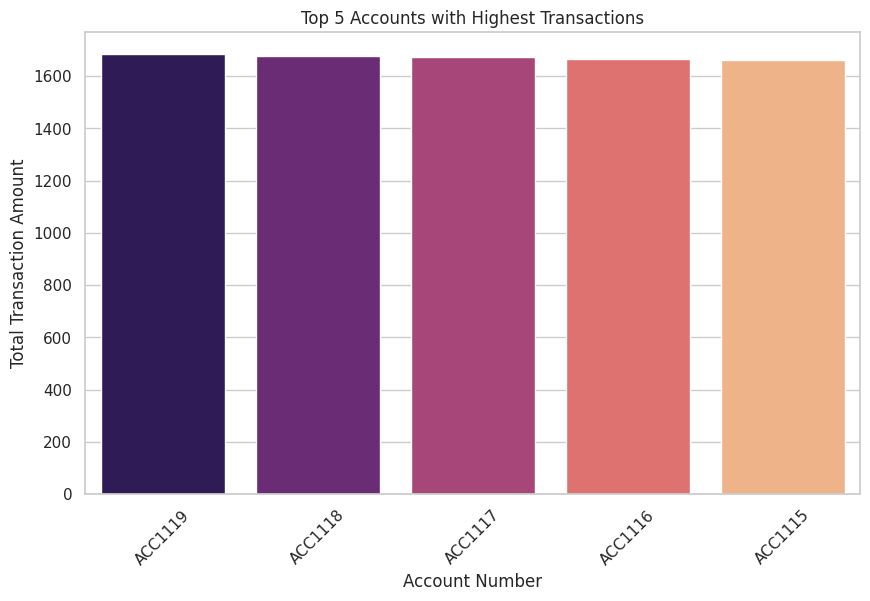

In [40]:
top_accounts = df.groupby("account_number")["amount"].sum().nlargest(5)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_accounts.index, y=top_accounts.values, palette="magma")
plt.title("Top 5 Accounts with Highest Transactions")
plt.xlabel("Account Number")
plt.ylabel("Total Transaction Amount")
plt.xticks(rotation=45)
plt.show()


**Heatmap of Transactions (Days vs. Hours)**

<ipython-input-41-c75a40462e0f>:8: FutureWarning: The provided callable <function sum at 0x795d339b82c0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  heatmap_data = df.pivot_table(index="day_of_week", columns="hour", values="amount", aggfunc=np.sum)


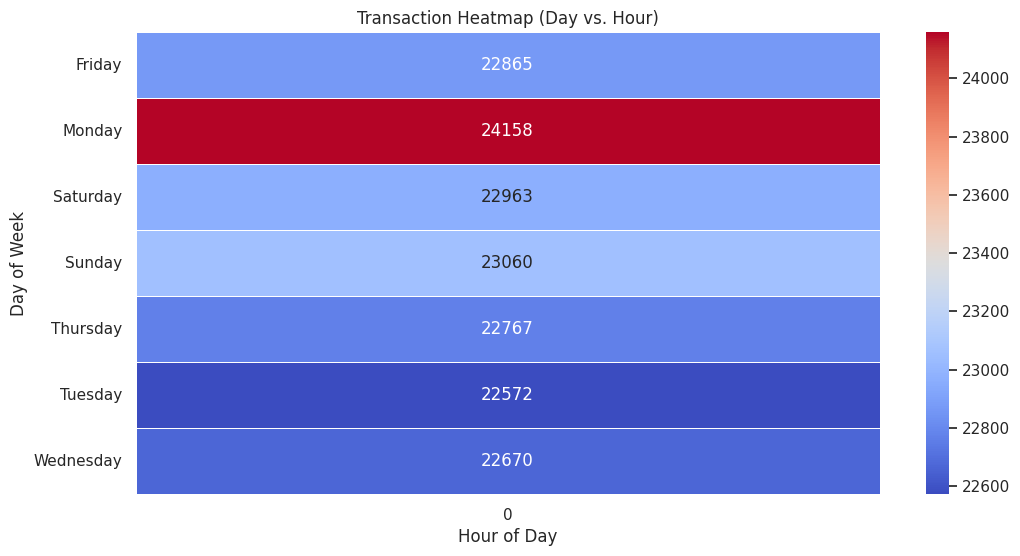

In [41]:
import numpy as np

# Extract day and hour
df["hour"] = df["transaction_date"].dt.hour
df["day_of_week"] = df["transaction_date"].dt.day_name()

# Create pivot table
heatmap_data = df.pivot_table(index="day_of_week", columns="hour", values="amount", aggfunc=np.sum)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="coolwarm", annot=True, fmt=".0f", linewidths=0.5)
plt.title("Transaction Heatmap (Day vs. Hour)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.show()
